In [5]:
import os
import re
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [6]:
def get_num(path, key='thresh', type=float, return_str=False):
    if type==float:
        res = re.findall(r'{}\d+\.\d+'.format(key), path)
    else:
        res = re.findall(r'{}[0-9]+'.format(key), path)
    if len(res) > 0:
        val = res[0].replace(key, '')
    else:
        val = str(-1)
    if return_str:
        return val
    else:
        return type(val)

def get_head(path):
    if 'freezetext' in path or 'freezehead' in path:
        if 'wit400m' in path:
            return 'Frozen CLIP'
        elif 'roberta' in path:
            return 'Frozen Roberta'
        else:
            raise NotImplementedError
    elif 'inittext' in path:
        if 'wit400m' in path:
            return 'CLIP Init'
        elif 'roberta' in path:
            return 'Roberta Init'
        else:
            raise NotImplementedError
    else:
        return 'Rand Init'

def get_cap_type(path):
    mapper = {
        'template_a+cname': 'Template (a [CLS])',
        'template_a+cname_synset': 'Template (Synset)',
        'template_openai80': 'Class Templates',
        'template_openai80_synset': 'Synset Templates',
        'text_description_only': 'Description Only',
        'text_title_only': 'Title Only',
        'text_tags_only': 'Tags Only',
        'text_no_tags': 'Title + Description',
        'text_no_title': 'Tags + Description',
        'text_no_description': 'Title + Tags',
        '': 'Full Text',
        'append_cname': 'Full Text + Template (a [CLS])',
        'append_openai80': 'Full Text + Class Templates',
        'append_openai80_synset': 'Full Text + Synset Templates',
    }
    postfix = path.split('/')[-3].split('-')[-1].replace('_no_cname', '') if ('-template' in path or '-text' in path or 'append' in path) else ''
    if 'supcls' in path:
        postfix = 'template_a+cname'
    return mapper[postfix]

def make_metrics(metric):
    out = {}
    accs, preds = metric['per_class_accs'].numpy(), metric['per_class_pred_cnt'].numpy()
    Sw_invSb, cos_M_all, cos_W_all, cos_M_nearest, cos_W_nearest, cos_within \
        = metric['Sw_invSb'].numpy(), metric['cos_M_all'].numpy(), metric['cos_W_all'].numpy(), metric['cos_M_nearest'].numpy(), metric['cos_W_nearest'].numpy(), metric['cos_within'].numpy()
    corr_acc, corr_pred, corr_Sw_invSb, corr_cos_M_all, corr_cos_W_all, corr_cos_M_nearest, corr_cos_W_nearest, corr_cos_within \
        = spearmanr(freqs, accs).statistic, spearmanr(freqs, preds).statistic, spearmanr(freqs, Sw_invSb).statistic, spearmanr(freqs, cos_M_all).statistic, \
          spearmanr(freqs, cos_W_all).statistic, spearmanr(freqs, cos_M_nearest).statistic, spearmanr(freqs, cos_W_nearest).statistic, spearmanr(freqs, cos_within).statistic
    corr_pred_acc, corr_Sw_invSb_acc, corr_cos_M_all_acc, corr_cos_W_all_acc, corr_cos_M_nearest_acc, corr_cos_W_nearest_acc, corr_cos_within_acc \
        = spearmanr(accs, preds).statistic, spearmanr(accs, Sw_invSb).statistic, spearmanr(accs, cos_M_all).statistic, spearmanr(accs, cos_W_all).statistic, \
            spearmanr(accs, cos_M_nearest).statistic, spearmanr(accs, cos_W_nearest).statistic, spearmanr(accs, cos_within).statistic
    out['top1'], out['Sw_invSb'], out['cos_M'], out['cos_W'], out['cos_M_nearest'], out['cos_W_nearest'], out['cos_within'] \
        = accs.mean(), Sw_invSb.mean(), cos_M_all.mean(), cos_W_all.mean(), cos_M_nearest.mean(), cos_W_nearest.mean(), cos_within.mean()
    out['corr_acc'], out['corr_pred'], out['corr_Sw_invSb'], out['corr_cos_M_all'], out['corr_cos_W_all'], out['corr_cos_M_nearest'], out['corr_cos_W_nearest'], out['corr_cos_within'] \
        = corr_acc, corr_pred, corr_Sw_invSb, corr_cos_M_all, corr_cos_W_all, corr_cos_M_nearest, corr_cos_W_nearest, corr_cos_within
    out['corr_pred_acc'], out['corr_Sw_invSb_acc'], out['corr_cos_M_all_acc'], out['corr_cos_W_all_acc'], out['corr_cos_M_nearest_acc'], out['corr_cos_W_nearest_acc'], out['corr_cos_within_acc'] \
        = corr_pred_acc, corr_Sw_invSb_acc, corr_cos_M_all_acc, corr_cos_W_all_acc, corr_cos_M_nearest_acc, corr_cos_W_nearest_acc, corr_cos_within_acc
    return out

def get_clip_metrics(paths):
    metrics = []
    for path in paths:
        if 'stats_val.jsonl' in path:
            path = path.replace('stats_val.jsonl', 'metrics/metrics_imagenet_zeroshot_val_latest.pt')
        if os.path.exists(path):
            metric = torch.load(path, map_location='cpu')
            dataset = 'LAIONet' if 'laionet' in path else 'ImageNet-Captions'
            model = 'CLIP' if 'open_clip' in path else 'SL'
            df_dict = {'Model': model, 'Dataset': dataset}
            if model != 'CLIP':
                continue
            df_dict['Text Head'] = get_head(path)
            df_dict['CLIP Cap. Type'] = get_cap_type(path)
            metric_dict = make_metrics(metric)
            df_dict.update(metric_dict)
            metrics.append(pd.DataFrame(df_dict, index=[0]))
    metrics = pd.concat(metrics)
    metrics = metrics.reset_index(drop=True)
    metrics.loc[:, 'top1'] *= 100
    return metrics

def get_sup_metrics(paths):
    metrics = []
    for path in paths:
        if 'stats_val.jsonl' in path:
            path = path.replace('stats_val.jsonl', 'metrics/metrics_val_latest.pt')
        if os.path.exists(path):
            metric = torch.load(path, map_location='cpu')
            dataset = 'LAIONet' if 'laionet' in path else 'ImageNet-Captions'
            model = 'CLIP' if 'open_clip' in path else 'SL'
            df_dict = {'Model': model, 'Dataset': dataset}
            if model == 'CLIP':
                continue
            df_dict['Text Head'] = get_head(path)
            df_dict['CLIP Cap. Type'] = get_cap_type(path)
            voc_size = get_num(path, key='samplehead', type=int)
            df_dict['Cls. Voc. Size'] = voc_size if voc_size != -1 else 1000
            df_dict['Sample Method'] = 'Uniform' if 'unfm' in path else 'Frequency' if 'linr' in path else 'All'
            metric_dict = make_metrics(metric)
            df_dict.update(metric_dict)
            metrics.append(pd.DataFrame(df_dict, index=[0]))
    metrics = pd.concat(metrics)
    metrics = metrics.reset_index(drop=True)
    metrics.loc[:, 'top1'] *= 100
    return metrics

freqs = pd.read_csv('../metadata/freqs/class_frequency_incap_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
idxs = np.argsort(freqs)[::-1]

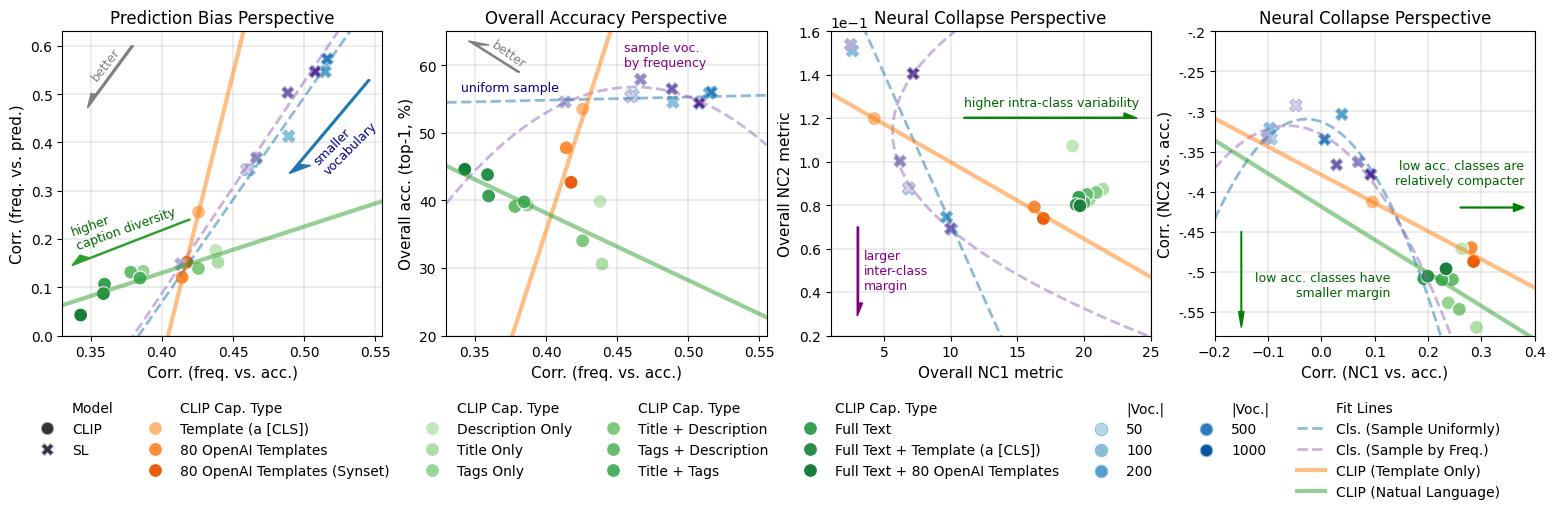

In [5]:
paths = [
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_20231227_023128/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead50_unfm/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead50_linr/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead100_unfm/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead100_linr/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead200_unfm/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead200_linr/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead500_unfm/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead500_linr/stats_val.jsonl',

    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-template_a+cname/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-template_openai80/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-template_openai80_synset/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_description_only/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_title_only/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_tags_only/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_no_tags/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_no_title/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_no_description/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-append_cname/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-append_openai80/stats_val.jsonl',
]

metrics = get_clip_metrics(paths)
metrics_template = metrics[metrics['CLIP Cap. Type'].str.contains("Template") & ~metrics['CLIP Cap. Type'].str.contains("Full Text")]
metrics_others = metrics[~metrics['CLIP Cap. Type'].str.contains("Template") | metrics['CLIP Cap. Type'].str.contains("Full Text")]
oranges = sns.color_palette('Oranges', n_colors=5)[1:-1]
greens = sns.color_palette('Greens', n_colors=14)[3:-2]
palette = oranges + greens
hue_order = ['Template (a [CLS])', '80 OpenAI Templates', '80 OpenAI Templates (Synset)', 'Description Only', 'Title Only', 'Tags Only', 'Title + Description', 'Tags + Description', 'Title + Tags', 'Full Text', 'Full Text + Template (a [CLS])', 'Full Text + 80 OpenAI Templates']
style_order = ['CLIP', 'SL']
fig, ax = plt.subplots(1, 4, figsize=(19, 4))

ax[0].grid(color='gray', linestyle='-', linewidth=0.3, alpha=0.7)
ax[1].grid(color='gray', linestyle='-', linewidth=0.3, alpha=0.7)
ax[2].grid(color='gray', linestyle='-', linewidth=0.3, alpha=0.7)
ax[3].grid(color='gray', linestyle='-', linewidth=0.3, alpha=0.7)

ax[0].set_box_aspect(.95)
ax[1].set_box_aspect(.95)
ax[2].set_box_aspect(.95)
ax[3].set_box_aspect(.95)

ax[0].set_xlim([.33, .555])
ax[0].set_ylim([0, .63])
ax[1].set_xlim([.33, .555])
ax[1].set_ylim([20, 65])
ax[2].set_xlim([1., 25])
ax[2].set_ylim([.02, .16])
ax[3].set_xlim([-.2, .4])
ax[3].set_ylim([-.58, -.2])

def my_formatter(x, pos):
    """Format 1 as 1, 0 as 0, and all values whose absolute values is between
    0 and 1 without the leading "0." (e.g., 0.7 is formatted as .7 and -0.4 is
    formatted as -.4)."""
    val_str = '{:g}'.format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str

major_formatter = matplotlib.ticker.FuncFormatter(my_formatter)

ax[1].set_yticks([20, 30, 40, 50, 60])
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(-2, -1))
ax[3].yaxis.set_major_formatter(major_formatter)


metrics_sup = get_sup_metrics(paths)
metrics_sup_unfm = pd.concat([metrics_sup[metrics_sup['Sample Method'] == 'Uniform'], metrics_sup[metrics_sup['Sample Method'] == 'All']])
metrics_sup_freq = pd.concat([metrics_sup[metrics_sup['Sample Method'] == 'Frequency'], metrics_sup[metrics_sup['Sample Method'] == 'All']])
metrics_sup_unfm_wo100 = metrics_sup_unfm[metrics_sup_unfm['Cls. Voc. Size'] != 100]
metrics_sup_freq_wo100 = metrics_sup_freq[metrics_sup_freq['Cls. Voc. Size'] != 100]

sns.regplot(metrics_sup_unfm, x='corr_acc', y='corr_pred', ax=ax[0], scatter=False, ci=None, truncate=False, color='tab:blue', line_kws={'alpha':.5, 'linewidth':2, 'linestyle': '--'})
sns.regplot(metrics_sup_unfm, x='corr_acc', y='top1', ax=ax[1], scatter=False, ci=None, truncate=False, color='tab:blue', line_kws={'alpha':.5, 'linewidth':2, 'linestyle': '--'})
sns.regplot(metrics_sup_unfm_wo100, x='Sw_invSb', y='cos_M', ax=ax[2], label='Cls. (Sample Uniformly)', scatter=False, ci=None, truncate=False, color='tab:blue', line_kws={'alpha':.5, 'linewidth':2, 'linestyle': '--'})
sns.regplot(metrics_sup_unfm, x='corr_Sw_invSb_acc', y='corr_cos_M_all_acc', ax=ax[3], label='Cls. (Sample Uniformly)', scatter=False, ci=None, truncate=False, color='tab:blue', order=2, line_kws={'alpha':.5, 'linewidth':2, 'linestyle': '--'})

sns.regplot(metrics_sup_freq, x='corr_acc', y='corr_pred', ax=ax[0], scatter=False, ci=None, truncate=False, color='tab:purple', line_kws={'alpha':.5, 'linewidth':2, 'linestyle': '--'})
sns.regplot(metrics_sup_freq, x='corr_acc', y='top1', ax=ax[1], scatter=False, ci=None, truncate=False, order=2, color='tab:purple', line_kws={'alpha':.5, 'linewidth':2, 'linestyle': '--'})
y = metrics_sup_freq_wo100['Sw_invSb'].to_numpy()
x = metrics_sup_freq_wo100['cos_M'].to_numpy()
p = np.poly1d(np.polyfit(x, y, 2))
y = np.arange(ax[2].get_ylim()[0], ax[2].get_ylim()[1] + .1, .005)
ax[2].plot(p(y), y, color='tab:purple', alpha=.5, linewidth=2, linestyle='--', label='Cls. (Sample by Freq.)')
sns.regplot(metrics_sup_freq, x='corr_Sw_invSb_acc', y='corr_cos_M_all_acc', ax=ax[3], label='Cls. (Sample by Freq.)', scatter=False, ci=None, truncate=False, order=2, color='tab:purple', line_kws={'alpha':.5, 'linewidth':2, 'linestyle': '--'})

sns.regplot(metrics_template, x='corr_acc', y='corr_pred', ax=ax[0], scatter=False, ci=None, truncate=False, color='tab:orange', line_kws={'alpha':.5, 'linewidth':3})
sns.regplot(metrics_template, x='corr_acc', y='top1', ax=ax[1], scatter=False, ci=None, truncate=False, color='tab:orange', line_kws={'alpha':.5, 'linewidth':3})
sns.regplot(metrics_template, x='Sw_invSb', y='cos_M', ax=ax[2], label='CLIP (Template Only)', scatter=False, ci=None, truncate=False, color='tab:orange', line_kws={'alpha':.5, 'linewidth':3})
sns.regplot(metrics_template, x='corr_Sw_invSb_acc', y='corr_cos_M_all_acc', ax=ax[3], label='CLIP (Template Only)', scatter=False, ci=None, truncate=False, color='tab:orange', line_kws={'alpha':.5, 'linewidth':3})

sns.regplot(metrics_others, x='corr_acc', y='corr_pred', ax=ax[0], scatter=False, ci=None, truncate=False, color='tab:green', line_kws={'alpha':.5, 'linewidth':3})
sns.regplot(metrics_others, x='corr_acc', y='top1', ax=ax[1], scatter=False, ci=None, truncate=False, color='tab:green', line_kws={'alpha':.5, 'linewidth':3})
sns.regplot(metrics_others, x='corr_Sw_invSb_acc', y='corr_cos_M_all_acc', ax=ax[3], label='CLIP (Natual Language)', scatter=False, ci=None, truncate=False, color='tab:green', line_kws={'alpha':.5, 'linewidth':3})

sns.scatterplot(metrics, x='corr_acc', y='corr_pred', hue='CLIP Cap. Type', hue_order=hue_order, style='Model', style_order=style_order, ax=ax[0], palette=palette, s=100)
sns.scatterplot(metrics, x='corr_acc', y='top1', hue='CLIP Cap. Type', hue_order=hue_order, style='Model', style_order=style_order, ax=ax[1], palette=palette, s=100)
sns.scatterplot(metrics, x='Sw_invSb', y='cos_M', hue='CLIP Cap. Type', hue_order=hue_order, style='Model', style_order=style_order, ax=ax[2], palette=palette, s=100)
sns.scatterplot(metrics, x='corr_Sw_invSb_acc', y='corr_cos_M_all_acc', hue='CLIP Cap. Type', hue_order=hue_order, style='Model', style_order=style_order, ax=ax[3], palette=palette, s=100)


blues = sns.color_palette('Blues', n_colors=6)[1:]
sns.scatterplot(metrics_sup_unfm, x='corr_acc', y='corr_pred', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[0], palette=blues, s=80, edgecolor=blues[1])
sns.scatterplot(metrics_sup_unfm, x='corr_acc', y='top1', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[1], palette=blues, s=80, edgecolor=blues[1])
sns.scatterplot(metrics_sup_unfm, x='Sw_invSb', y='cos_M', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[2], palette=blues, s=80, edgecolor=blues[1])
sns.scatterplot(metrics_sup_unfm, x='corr_Sw_invSb_acc', y='corr_cos_M_all_acc', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[3], palette=blues, s=80, edgecolor=blues[1])
purples = sns.color_palette('Purples', n_colors=6)[1:]
sns.scatterplot(metrics_sup_freq, x='corr_acc', y='corr_pred', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[0], palette=purples, s=80, edgecolor=purples[1])
sns.scatterplot(metrics_sup_freq, x='corr_acc', y='top1', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[1], palette=purples, s=80, edgecolor=purples[1])
sns.scatterplot(metrics_sup_freq, x='Sw_invSb', y='cos_M', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[2], palette=purples, s=80, edgecolor=purples[1])
sns.scatterplot(metrics_sup_freq, x='corr_Sw_invSb_acc', y='corr_cos_M_all_acc', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[3], palette=purples, s=80, edgecolor=purples[1])

ax[0].set_xlabel('Corr. (freq. vs. acc.)', fontsize=11)
ax[0].set_ylabel('Corr. (freq. vs. pred.)', fontsize=11)
ax[1].set_xlabel('Corr. (freq. vs. acc.)', fontsize=11)
ax[1].set_ylabel('Overall acc. (top-1, %)', fontsize=11)
ax[2].set_xlabel('Overall NC1 metric', fontsize=11)
ax[2].set_ylabel('Overall NC2 metric', fontsize=11)
ax[3].set_xlabel('Corr. (NC1 vs. acc.)', fontsize=11)
ax[3].set_ylabel('Corr. (NC2 vs. acc.)', fontsize=11)

ax[0].set_title('Prediction Bias Perspective')
ax[1].set_title('Overall Accuracy Perspective')
ax[2].set_title('Neural Collapse Perspective')
ax[3].set_title('Neural Collapse Perspective')

ax[0].arrow(.42, .24, -.07, -.08, width=.003, head_width=0.02, head_length=0.02, fc='tab:green', ec='tab:green', shape='left')
ax[0].text(.335, .3, 'higher\ncaption diversity', fontsize=9, color='darkgreen', ha='left', va='top', rotation=19.5)
ax[0].arrow(.545, .53, -.05, -.175, width=.003, head_width=0.02, head_length=0.02, fc='tab:blue', ec='tab:blue', shape='right')
ax[0].text(.505, .47, 'smaller\nvocabulary', fontsize=9, color='darkblue', ha='left', va='top', rotation=45)
ax[0].arrow(.38, .6, -.025, -.1, width=.003, head_width=0.01, head_length=0.03, fc='gray', ec='gray', shape='left')
ax[0].text(.349, .603, 'better', fontsize=9, color='gray', ha='left', va='top', rotation=52)


ax[1].arrow(.38, 59, -.03, 4, width=.003, head_width=0.02, head_length=0.6, fc='gray', ec='gray', shape='left')
ax[1].text(.36, 64, 'better', fontsize=9, color='gray', ha='left', va='top', rotation=-35)
ax[1].text(.455, 63.5, 'sample voc.\nby frequency', fontsize=9, color='purple', ha='left', va='top', rotation=0)
ax[1].text(.34, 57.7, 'uniform sample', fontsize=9, color='darkblue', ha='left', va='top', rotation=0)

ax[2].arrow(11, .12, 12, 0, width=.001, head_width=0.005, head_length=1, fc='green', ec='green', shape='right')
ax[2].text(11, .13, 'higher intra-class variability', fontsize=9, color='darkgreen', ha='left', va='top', rotation=0)
ax[2].arrow(3, .07, 0, -.035, width=.2, head_width=.8, head_length=.006, fc='purple', ec='purple', shape='right')
ax[2].text(3.5, .04, 'larger\ninter-class\nmargin', fontsize=9, color='purple', ha='left', va='bottom', rotation=0)

ax[3].arrow(-.15, -.45, 0, -.1, width=.001, head_width=0.01, head_length=0.02, fc='green', ec='green', shape='full')
ax[3].text(.13, -.50, 'low acc. classes have\nsmaller margin', fontsize=9, color='darkgreen', ha='right', va='top', rotation=0)
ax[3].arrow(.26, -.42, .1, 0, width=.001, head_width=0.01, head_length=0.02, fc='green', ec='green', shape='full')
ax[3].text(.38, -.36, 'low acc. classes are\nrelatively compacter', fontsize=9, color='darkgreen', ha='right', va='top', rotation=0)

ax[0].legend().remove()
ax[1].legend().remove()
ax[2].legend().remove()
l = matplotlib.lines.Line2D([], [], color="none")
handles, labels = ax[3].get_legend_handles_labels()
handles = handles[-3:] + [l]*2 + handles[4:8] + [l] + [handles[4]] + handles[8:11] + [l] + [handles[4]] + handles[11:14] + [l] + [handles[4]] + handles[14:17] + [l] + [l] + handles[21:24] + [l] + [l] + handles[24:26] + [l] + [l]*2 + handles[:4]
labels = labels[-3:] + ['']*2 + labels[4:8] + [''] + [labels[4]] + labels[8:11] + [''] + [labels[4]] + labels[11:14] + [''] + [labels[4]] + labels[14:17] + [''] + ['|Voc.|'] + labels[21:24] + [''] + ['|Voc.|'] + labels[24:26] + ['']*2 + ['Fit Lines'] + labels[:4]
plt.legend(handles, labels, loc='lower center', bbox_to_anchor=(-1.4, -.58), ncol=8, frameon=False)
plt.show()

# fig.savefig('figs/clip_vs_cls.pdf', bbox_inches='tight', dpi=300)

/var/folders/8z/bwhvzd4967b76fpt8fp9q9sr0000gn/T/ipykernel_39587/3047372345.py:94: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(metrics_sup_freq, x='corr_acc', y='top1', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[1], palette=blues, s=200, markers='X', zorder=3) # , edgecolor=blues[1])


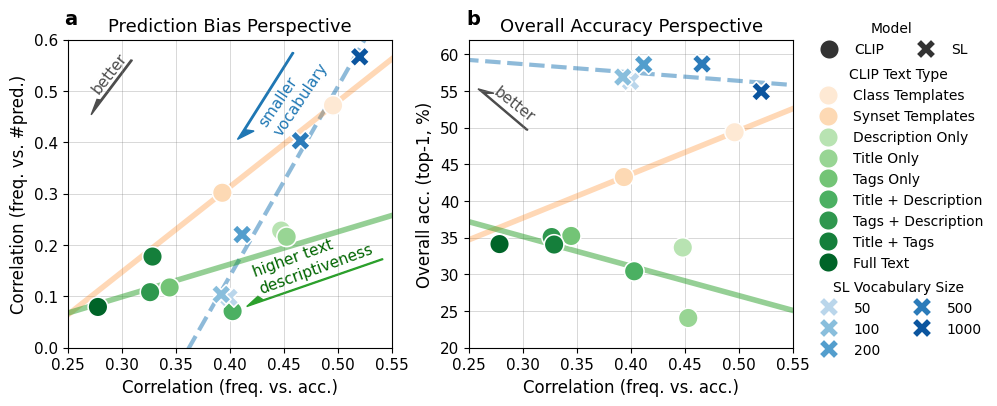

In [5]:
# smaller version of the upper
paths = [
    '../exps_sup/output/rn50_incaps_supcls_bs256_20231227_023045/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_samplehead50_linr/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_samplehead100_linr/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_samplehead200_linr/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_samplehead500_linr/stats_val.jsonl',

    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-template_openai80/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-template_openai80_synset/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-text_description_only/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-text_title_only/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-text_tags_only/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-text_no_tags/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-text_no_title/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-text_no_description/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp/stats_val.jsonl',
]

metrics = get_clip_metrics(paths)
metrics_template = metrics[metrics['CLIP Cap. Type'].str.contains("Template") & ~metrics['CLIP Cap. Type'].str.contains("Full Text")]
metrics_others = metrics[~metrics['CLIP Cap. Type'].str.contains("Template") | metrics['CLIP Cap. Type'].str.contains("Full Text")]
oranges = sns.color_palette('Oranges', n_colors=9)[:2]
greens = sns.color_palette('Greens', n_colors=9)[2:]
palette = oranges + greens
hue_order = ['Class Templates', 'Synset Templates', 'Description Only', 'Title Only', 'Tags Only', 'Title + Description', 'Tags + Description', 'Title + Tags', 'Full Text']
style_order = ['CLIP', 'SL']
fig, ax = plt.subplots(1, 2, figsize=(9.5, 4))

ax[0].grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.3)
ax[1].grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.3)

metrics_sup = get_sup_metrics(paths)
metrics_sup_freq = pd.concat([metrics_sup[metrics_sup['Sample Method'] == 'Frequency'], metrics_sup[metrics_sup['Sample Method'] == 'All']])

sns.regplot(metrics_sup_freq, x='corr_acc', y='corr_pred', ax=ax[0], scatter=False, ci=None, truncate=False, color='tab:blue', line_kws={'alpha':.5, 'linewidth':3, 'linestyle': '--'})
sns.regplot(metrics_sup_freq, x='corr_acc', y='top1', ax=ax[1], scatter=False, ci=None, truncate=False, order=1, color='tab:blue', line_kws={'alpha':.5, 'linewidth':3, 'linestyle': '--'})

sns.regplot(metrics_template, x='corr_acc', y='corr_pred', ax=ax[0], scatter=False, ci=None, truncate=False, color='tab:orange', line_kws={'alpha':.3, 'linewidth':4})
sns.regplot(metrics_template, x='corr_acc', y='top1', ax=ax[1], scatter=False, ci=None, truncate=False, color='tab:orange', line_kws={'alpha':.3, 'linewidth':4})

sns.regplot(metrics_others, x='corr_acc', y='corr_pred', ax=ax[0], scatter=False, ci=None, truncate=False, color='tab:green', line_kws={'alpha':.5, 'linewidth':4})
sns.regplot(metrics_others[metrics_others['top1'] > 20], x='corr_acc', y='top1', ax=ax[1], scatter=False, ci=None, truncate=False, color='tab:green', line_kws={'alpha':.5, 'linewidth':4})
sns.scatterplot(metrics, x='corr_acc', y='corr_pred', hue='CLIP Cap. Type', hue_order=hue_order, style='Model', style_order=style_order, ax=ax[0], palette=palette, s=200, zorder=3)
sns.scatterplot(metrics, x='corr_acc', y='top1', hue='CLIP Cap. Type', hue_order=hue_order, style='Model', style_order=style_order, ax=ax[1], palette=palette, s=200, zorder=3)

blues = sns.color_palette('Blues', n_colors=6)[1:]
sns.scatterplot(metrics_sup_freq, x='corr_acc', y='corr_pred', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[0], palette=blues, s=200, zorder=3) #, edgecolor=blues[1])
sns.scatterplot(metrics_sup_freq, x='corr_acc', y='top1', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[1], palette=blues, s=200, markers='X', zorder=3) # , edgecolor=blues[1])

ax[0].set_xlabel('Correlation (freq. vs. acc.)', fontsize=12)
ax[0].set_ylabel('Correlation (freq. vs. #pred.)', fontsize=12)
ax[1].set_xlabel('Correlation (freq. vs. acc.)', fontsize=12)
ax[1].set_ylabel('Overall acc. (top-1, %)', fontsize=12)
ax[0].xaxis.set_tick_params(labelsize=11, rotation=0)
ax[0].yaxis.set_tick_params(labelsize=11, rotation=0)
ax[1].xaxis.set_tick_params(labelsize=11, rotation=0)
ax[1].yaxis.set_tick_params(labelsize=11, rotation=0)

ax[0].set_box_aspect(.95)
ax[1].set_box_aspect(.95)

ax[0].set_xlim([.25, .55])
ax[0].set_ylim([0, .6])
ax[1].set_xlim([.25, .55])
ax[1].set_ylim([20, 62])

ax[0].set_title('Prediction Bias Perspective', fontsize=13)
ax[1].set_title('Overall Accuracy Perspective', fontsize=13)

ax[0].arrow(.542, .172, -.11, -.08, width=.003, head_width=0.02, head_length=0.02, fc='tab:green', ec='tab:green', shape='left')
ax[0].text(.42, .24, 'higher text\ndescriptiveness', fontsize=11, color='darkgreen', ha='left', va='top', rotation=20)
ax[0].arrow(.458, .575, -.045, -.15, width=.003, head_width=0.02, head_length=0.02, fc='tab:blue', ec='tab:blue', shape='right')
ax[0].text(.425, .58, 'smaller\nvocabulary', fontsize=11, color='tab:blue', ha='left', va='top', rotation=56)

ax[0].arrow(.31, .56, -.028, -.078, width=.003, head_width=0.01, head_length=0.03, fc='0.3', ec='0.3', shape='left')
ax[0].text(.27, .58, 'better', fontsize=11, color='0.3', ha='left', va='top', rotation=52)
ax[1].arrow(.303, 49.7, -.04, 5, width=.003, head_width=0.02, head_length=0.6, fc='0.3', ec='0.3', shape='left')
ax[1].text(.27, 56, 'better', fontsize=11, color='0.3', ha='left', va='top', rotation=-38)

ax[0].text(-.01, 1.05, 'a', fontsize=14, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(-.01, 1.05, 'b', fontsize=14, fontweight='bold', transform=ax[1].transAxes)

ax[0].legend().remove()
ax[1].legend().remove()
l = matplotlib.lines.Line2D([], [], color="none")
handles, labels = ax[0].get_legend_handles_labels()
legend1 = plt.legend(handles[1:10], labels[1:10], title='CLIP Text Type', loc='upper right', bbox_to_anchor=(1.624, 0.95), frameon=False, fontsize=10)
legend2 = plt.legend(handles[-2:], labels[-2:], title='Model', loc='upper right', bbox_to_anchor=(1.575, 1.1), ncol=2, frameon=False)
handles, labels = ax[1].get_legend_handles_labels()
plt.legend(handles[14:-3], labels[14:-3], title='SL Vocabulary Size', loc='upper right', ncol=2, bbox_to_anchor=(1.62, .26), frameon=False)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.show()

fig.savefig('figs/clip_vs_cls_scratch.pdf', bbox_inches='tight', dpi=300)

/var/folders/8z/bwhvzd4967b76fpt8fp9q9sr0000gn/T/ipykernel_68047/2294720309.py:94: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(metrics_sup_freq, x='corr_acc', y='top1', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[1], palette=blues, s=200, markers='X', zorder=3) # , edgecolor=blues[1])


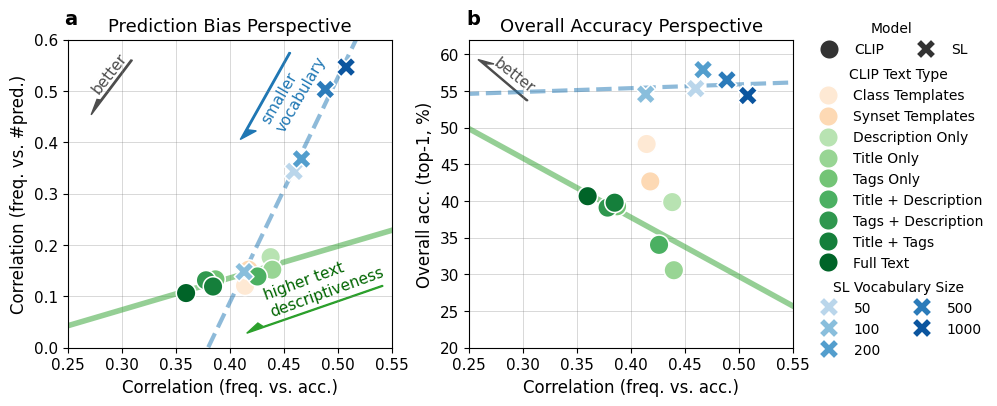

In [26]:
# with frozen pre-trained heads
paths = [

    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_20231227_023128/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead50_linr/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead100_linr/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead200_linr/stats_val.jsonl',
    '../exps_sup/output/rn50_incaps_supcls_bs256_freezehead_in1k_clip_rn50_wit400m_a+cname_samplehead500_linr/stats_val.jsonl',

    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-template_openai80/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-template_openai80_synset/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_description_only/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_title_only/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_tags_only/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_no_tags/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_no_title/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m-text_no_description/stats_val.jsonl',
    '../exps_clip/logs/RN50-lr_0.001-b_1024-e_32-p_amp-freezetext_clip_wit400m/stats_val.jsonl',
]

metrics = get_clip_metrics(paths)
metrics_template = metrics[metrics['CLIP Cap. Type'].str.contains("Template") & ~metrics['CLIP Cap. Type'].str.contains("Full Text")]
metrics_others = metrics[~metrics['CLIP Cap. Type'].str.contains("Template") | metrics['CLIP Cap. Type'].str.contains("Full Text")]
oranges = sns.color_palette('Oranges', n_colors=9)[:2]
greens = sns.color_palette('Greens', n_colors=9)[2:]
palette = oranges + greens
hue_order = ['Class Templates', 'Synset Templates', 'Description Only', 'Title Only', 'Tags Only', 'Title + Description', 'Tags + Description', 'Title + Tags', 'Full Text']
style_order = ['CLIP', 'SL']
fig, ax = plt.subplots(1, 2, figsize=(9.5, 4))

ax[0].grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.3)
ax[1].grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.3)

metrics_sup = get_sup_metrics(paths)
metrics_sup_freq = pd.concat([metrics_sup[metrics_sup['Sample Method'] == 'Frequency'], metrics_sup[metrics_sup['Sample Method'] == 'All']])

sns.regplot(metrics_sup_freq, x='corr_acc', y='corr_pred', ax=ax[0], scatter=False, ci=None, truncate=False, color='tab:blue', line_kws={'alpha':.5, 'linewidth':3, 'linestyle': '--'})
sns.regplot(metrics_sup_freq, x='corr_acc', y='top1', ax=ax[1], scatter=False, ci=None, truncate=False, order=1, color='tab:blue', line_kws={'alpha':.5, 'linewidth':3, 'linestyle': '--'})

sns.regplot(metrics_others, x='corr_acc', y='corr_pred', ax=ax[0], scatter=False, ci=None, truncate=False, color='tab:green', line_kws={'alpha':.5, 'linewidth':4})
sns.regplot(metrics_others[metrics_others['top1'] > 20], x='corr_acc', y='top1', ax=ax[1], scatter=False, ci=None, truncate=False, color='tab:green', line_kws={'alpha':.5, 'linewidth':4})
sns.scatterplot(metrics, x='corr_acc', y='corr_pred', hue='CLIP Cap. Type', hue_order=hue_order, style='Model', style_order=style_order, ax=ax[0], palette=palette, s=200, zorder=3)
sns.scatterplot(metrics, x='corr_acc', y='top1', hue='CLIP Cap. Type', hue_order=hue_order, style='Model', style_order=style_order, ax=ax[1], palette=palette, s=200, zorder=3)

blues = sns.color_palette('Blues', n_colors=6)[1:]
sns.scatterplot(metrics_sup_freq, x='corr_acc', y='corr_pred', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[0], palette=blues, s=200, zorder=3) #, edgecolor=blues[1])
sns.scatterplot(metrics_sup_freq, x='corr_acc', y='top1', hue='Cls. Voc. Size', style='Model', style_order=style_order, ax=ax[1], palette=blues, s=200, markers='X', zorder=3) # , edgecolor=blues[1])

ax[0].set_xlabel('Correlation (freq. vs. acc.)', fontsize=12)
ax[0].set_ylabel('Correlation (freq. vs. #pred.)', fontsize=12)
ax[1].set_xlabel('Correlation (freq. vs. acc.)', fontsize=12)
ax[1].set_ylabel('Overall acc. (top-1, %)', fontsize=12)
ax[0].xaxis.set_tick_params(labelsize=11, rotation=0)
ax[0].yaxis.set_tick_params(labelsize=11, rotation=0)
ax[1].xaxis.set_tick_params(labelsize=11, rotation=0)
ax[1].yaxis.set_tick_params(labelsize=11, rotation=0)

ax[0].set_box_aspect(.95)
ax[1].set_box_aspect(.95)

ax[0].set_xlim([.25, .55])
ax[0].set_ylim([0, .6])
ax[1].set_xlim([.25, .55])
ax[1].set_ylim([20, 62])

ax[0].set_title('Prediction Bias Perspective', fontsize=13)
ax[1].set_title('Overall Accuracy Perspective', fontsize=13)

ax[0].arrow(.542, .12, -.11, -.08, width=.003, head_width=0.02, head_length=0.02, fc='tab:green', ec='tab:green', shape='left')
ax[0].text(.43, .195, 'higher text\ndescriptiveness', fontsize=11, color='darkgreen', ha='left', va='top', rotation=20)
ax[0].arrow(.455, .575, -.04, -.15, width=.003, head_width=0.02, head_length=0.02, fc='tab:blue', ec='tab:blue', shape='right')
ax[0].text(.427, .59, 'smaller\nvocabulary', fontsize=11, color='tab:blue', ha='left', va='top', rotation=60)

ax[0].arrow(.31, .56, -.028, -.078, width=.003, head_width=0.01, head_length=0.03, fc='0.3', ec='0.3', shape='left')
ax[0].text(.27, .58, 'better', fontsize=11, color='0.3', ha='left', va='top', rotation=52)
ax[1].arrow(.303, 53.7, -.04, 5, width=.003, head_width=0.02, head_length=0.6, fc='0.3', ec='0.3', shape='left')
ax[1].text(.27, 60, 'better', fontsize=11, color='0.3', ha='left', va='top', rotation=-38)

ax[0].text(-.01, 1.05, 'a', fontsize=14, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(-.01, 1.05, 'b', fontsize=14, fontweight='bold', transform=ax[1].transAxes)

ax[0].legend().remove()
ax[1].legend().remove()
l = matplotlib.lines.Line2D([], [], color="none")
handles, labels = ax[0].get_legend_handles_labels()
legend1 = plt.legend(handles[1:10], labels[1:10], title='CLIP Text Type', loc='upper right', bbox_to_anchor=(1.624, 0.95), frameon=False, fontsize=10)
legend2 = plt.legend(handles[-2:], labels[-2:], title='Model', loc='upper right', bbox_to_anchor=(1.575, 1.1), ncol=2, frameon=False)
handles, labels = ax[1].get_legend_handles_labels()
plt.legend(handles[14:-3], labels[14:-3], title='SL Vocabulary Size', loc='upper right', ncol=2, bbox_to_anchor=(1.62, .26), frameon=False)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.show()

fig.savefig('figs/clip_vs_cls.pdf', bbox_inches='tight', dpi=300)